In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [105]:
# Import data from 
data_base = pd.read_csv("G:/.shortcut-targets-by-id/1SNU6AKxzBtTEAum9YeqKtgoTzKPg9vZX/Creative/Solver - Tableros Comandos/Supermart Grocery Sales - Retail Analytics Dataset.csv")

# Transform date column in correct format
data_base['Order Date']  = pd.to_datetime(data_base['Order Date'])

# Create a variable to work and data_base state as backup
data = data_base

#Resume
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9994 non-null   object        
 1   Customer Name  9994 non-null   object        
 2   Category       9994 non-null   object        
 3   Sub Category   9994 non-null   object        
 4   City           9994 non-null   object        
 5   Order Date     9994 non-null   datetime64[ns]
 6   Region         9994 non-null   object        
 7   Sales          9994 non-null   int64         
 8   Discount       9994 non-null   float64       
 9   Profit         9994 non-null   float64       
 10  State          9994 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 859.0+ KB


In [106]:
#Analize numerical data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,9994.0,1496.596158,577.559036,500.00,1000.0000,1498.00,1994.7500,2500.00
Discount,9994.0,0.226817,0.074636,0.10,0.1600,0.23,0.2900,0.35
Profit,9994.0,374.937082,239.932881,25.25,180.0225,320.78,525.6275,1120.95


In [107]:
#Transform 'Order Date' into date format
data['Order Date'] = pd.to_datetime(data['Order Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9994 non-null   object        
 1   Customer Name  9994 non-null   object        
 2   Category       9994 non-null   object        
 3   Sub Category   9994 non-null   object        
 4   City           9994 non-null   object        
 5   Order Date     9994 non-null   datetime64[ns]
 6   Region         9994 non-null   object        
 7   Sales          9994 non-null   int64         
 8   Discount       9994 non-null   float64       
 9   Profit         9994 non-null   float64       
 10  State          9994 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 859.0+ KB


In [108]:
#Create s subdata set for RFM analysis
df = data[['Order ID', 'Customer Name','Order Date','Profit']]
df.columns = [  'InvoiceNo',
                'CustomerID',
                'InvoiceDate', 
                'TotalSum']
df

,InvoiceNo,CustomerID,InvoiceDate,TotalSum
0,OD1,Harish,2017-11-08,401.28
1,OD2,Sudha,2017-11-08,149.80
2,OD3,Hussain,2017-06-12,165.20
3,OD4,Jackson,2016-10-11,89.60
4,OD5,Ridhesh,2016-10-11,918.45
...,...,...,...,...
9989,OD9990,Sudeep,2015-12-24,359.10
9990,OD9991,Alan,2015-07-12,71.70
9991,OD9992,Ravi,2017-06-06,501.44
9992,OD9993,Peer,2018-10-16,597.24


In [109]:
# the max date are the max InvoiceData plus 1 day
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1) 

# Calculate by cliente  Recency, Frequency y Monetary
data_process = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'count', # Frequency
    'TotalSum': 'sum'}) # Monetary

# Rename name columns 
data_process.rename(columns = {'InvoiceDate': 'Recency',
                               'InvoiceNo': 'Frequency',
                               'TotalSum': 'MonetaryValue'}, inplace=True)

In [110]:
# We divide the data into quartiles for Recency and MonetaryValue
# We use custom labels for the quartiles
r_labels = range(3, 0, -1)  # Ascending labels for 4 quartiles
m_labels = range(1, 4)  # Ascending labels for 4 quartiles
r_quartiles = pd.qcut(data_process['Recency'], 3, labels=r_labels)
m_quartiles = pd.qcut(data_process['MonetaryValue'], 3, labels=m_labels)

# We divide the data into quartiles for Frequency
f_labels = range(1, 4)  # Three labels for three quartiles
f_quartiles = pd.qcut(data_process['Frequency'], 3, labels=f_labels)

# We assign the labels to our data
data_process = data_process.assign(R=r_quartiles.values)
data_process = data_process.assign(F=f_quartiles.values)
data_process = data_process.assign(M=m_quartiles.values)

# We calculate the RFM Score by summing the values of R, F, and M
data_process['RFM_Score'] = data_process[['R', 'F', 'M']].sum(axis=1)

# We visualize the first records of the processed data
data_process.head()


,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score
CustomerID,,,,,,,
Adavan,8,205,78044.29,1,3,3,7
Aditi,2,187,78439.05,3,1,3,7
Akash,3,196,82121.26,3,1,3,7
Alan,7,198,74410.23,1,2,2,5
Amrish,4,227,80191.89,2,3,3,8


In [111]:
# Define conditions and corresponding labels
        ## You can modify this section for each business problem
conditions = [
    ((data_process['M'] == 3) & (data_process['F'] == 3) & (data_process['R'] == 3)),
    ((data_process['M'] == 3) & (data_process['F'] == 2) & (data_process['R'] == 3)),
    ((data_process['M'] == 3) & (data_process['F'] == 3) & (data_process['R'] == 2)),
    ((data_process['M'] == 3) & (data_process['F'] == 3) & (data_process['R'] == 1)),
    ((data_process['M'] == 3) & (data_process['F'] == 1) & (data_process['R'] == 3)),
    ((data_process['M'] == 3) & (data_process['F'] == 2) & (data_process['R'] == 2)),
    ((data_process['M'] == 3) & (data_process['F'] == 2) & (data_process['R'] == 1)),
    ((data_process['M'] == 3) & (data_process['F'] == 1) & (data_process['R'] == 2)),
    ((data_process['M'] == 3) & (data_process['F'] == 1) & (data_process['R'] == 1)),
    ((data_process['M'] == 2) & (data_process['F'] == 3) & (data_process['R'] == 3)),
    ((data_process['M'] == 2) & (data_process['F'] == 2) & (data_process['R'] == 3)),
    ((data_process['M'] == 2) & (data_process['F'] == 3) & (data_process['R'] == 2)),
    ((data_process['M'] == 2) & (data_process['F'] == 2) & (data_process['R'] == 2)),
    ((data_process['M'] == 2) & (data_process['F'] == 1) & (data_process['R'] == 3)),
    ((data_process['M'] == 2) & (data_process['F'] == 3) & (data_process['R'] == 1)),
    ((data_process['M'] == 2) & (data_process['F'] == 2) & (data_process['R'] == 1)),
    ((data_process['M'] == 2) & (data_process['F'] == 1) & (data_process['R'] == 2)),
    ((data_process['M'] == 2) & (data_process['F'] == 1) & (data_process['R'] == 1)),
    ((data_process['M'] == 1) & (data_process['F'] == 3) & (data_process['R'] == 3)),
    ((data_process['M'] == 1) & (data_process['F'] == 2) & (data_process['R'] == 3)),
    ((data_process['M'] == 1) & (data_process['F'] == 3) & (data_process['R'] == 2)),
    ((data_process['M'] == 1) & (data_process['F'] == 3) & (data_process['R'] == 1)),
    ((data_process['M'] == 1) & (data_process['F'] == 2) & (data_process['R'] == 2)),
    ((data_process['M'] == 1) & (data_process['F'] == 1) & (data_process['R'] == 3)),
    ((data_process['M'] == 1) & (data_process['F'] == 2) & (data_process['R'] == 1)),
    ((data_process['M'] == 1) & (data_process['F'] == 1) & (data_process['R'] == 2)),
    ((data_process['M'] == 1) & (data_process['F'] == 1) & (data_process['R'] == 1))
]

choices = ['Gold', 'Gold', 'Gold', 'At risk', 'Gold', 'Gold', 'At risk', 'Gold', 'At risk', 'Gold',
           'Gold', 'Potential', 'Potential', 'Potential', 'Potential', 'Potential', 'Low Value', 'Low Value',
           'Gold', 'Potential', 'Potential', 'Low Value', 'Low Value', 'New Customer', 'Low Value', 'Low Value', 'Low Value']

# Apply conditions and choices to create 'Cliente' column
data_process['Cliente'] = np.select(conditions, choices, default=np.nan)



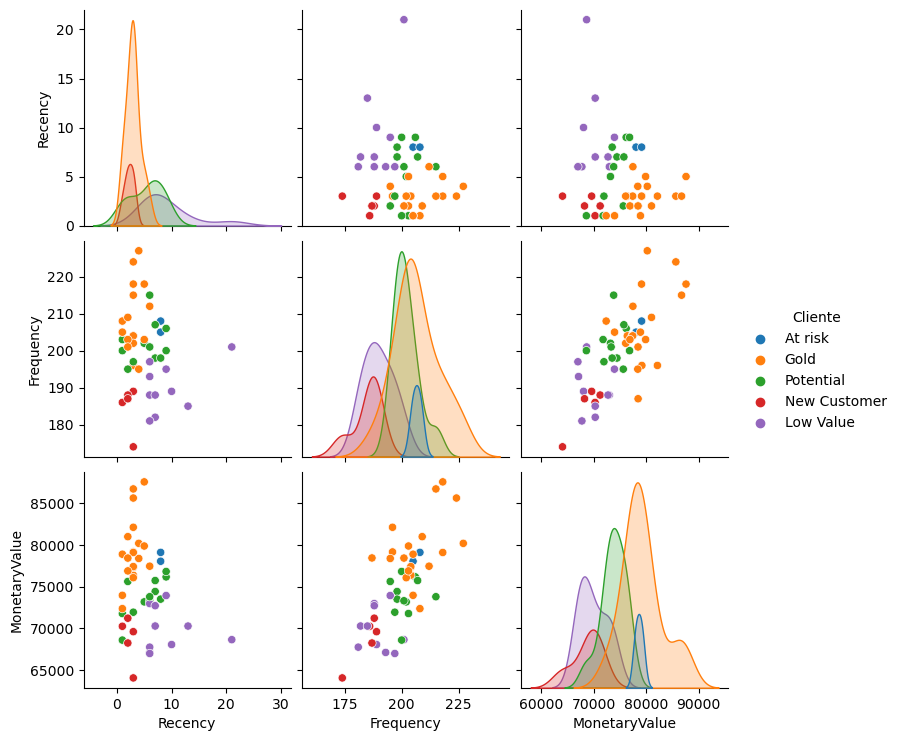

In [112]:
#Visualize RFM analysis
sns.pairplot(data_process[['Recency','Frequency','MonetaryValue','Cliente']], hue= 'Cliente')
plt.show()

In [113]:
# Merge the RFM analysis with the initial dataset
data_export = data_base
data_export = pd.merge(data_export,data_process,left_on='Customer Name', right_on='CustomerID')
data_export

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,Cliente
0,OD1,Harish,Oil & Masala,Masalas,Vellore,2017-11-08,North,1254,0.12,401.28,Tamil Nadu,8,208,79107.83,1,3,3,7,At risk
1,OD122,Harish,Bakery,Cakes,Krishnagiri,2017-06-12,East,649,0.34,201.19,Tamil Nadu,8,208,79107.83,1,3,3,7,At risk
2,OD128,Harish,Oil & Masala,Spices,Tirunelveli,2018-11-05,West,1293,0.23,336.18,Tamil Nadu,8,208,79107.83,1,3,3,7,At risk
3,OD135,Harish,Beverages,Health Drinks,Ramanadhapuram,2017-10-13,West,2373,0.18,664.44,Tamil Nadu,8,208,79107.83,1,3,3,7,At risk
4,OD148,Harish,Fruits & Veggies,Fresh Vegetables,Tirunelveli,2017-12-05,Central,1125,0.33,292.50,Tamil Nadu,8,208,79107.83,1,3,3,7,At risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,OD9842,Surya,Food Grains,Atta & Flour,Viluppuram,2018-01-21,Central,1398,0.19,83.88,Tamil Nadu,2,209,80996.85,3,3,3,9,Gold
9990,OD9845,Surya,Fruits & Veggies,Organic Fruits,Virudhunagar,2018-01-21,Central,1028,0.23,339.24,Tamil Nadu,2,209,80996.85,3,3,3,9,Gold
9991,OD9917,Surya,Oil & Masala,Masalas,Krishnagiri,2015-01-26,South,1350,0.34,499.50,Tamil Nadu,2,209,80996.85,3,3,3,9,Gold
9992,OD9965,Surya,Food Grains,Rice,Tenkasi,2018-05-30,West,2040,0.32,244.80,Tamil Nadu,2,209,80996.85,3,3,3,9,Gold


In [114]:
# Only for the data-viz we chance Regio by Stores ands Cities by Salesperson

tienda = data_export[['Region']].drop_duplicates()
tienda['Tiendas'] = ['Store D','Store B','Store C','Store A','Store E']

vendedor = data_export[['City']].drop_duplicates()
vendedor['Vendedor'] = ['Salesperson A', 'Salesperson B', 'Salesperson C', 'Salesperson D', 'Salesperson E',
                           'Salesperson F', 'Salesperson G', 'Salesperson H', 'Salesperson I', 'Salesperson J',
                           'Salesperson K', 'Salesperson L', 'Salesperson M', 'Salesperson N', 'Salesperson O',
                           'Salesperson P', 'Salesperson Q', 'Salesperson R', 'Salesperson S', 'Salesperson T',
                           'Salesperson U', 'Salesperson V', 'Salesperson W', 'Salesperson X']

In [115]:
#Merge data with Sales Date
data_export = pd.merge(data_export,tienda)
data_export = pd.merge(data_export,vendedor)
data_export

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,...,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,Cliente,Tiendas,Vendedor
0,OD1,Harish,Oil & Masala,Masalas,Vellore,2017-11-08,North,1254,0.12,401.28,...,8,208,79107.83,1,3,3,7,At risk,Store D,Salesperson A
1,OD1050,Jackson,Snacks,Cookies,Vellore,2015-10-04,East,842,0.11,370.48,...,7,182,70268.59,1,1,1,3,Low Value,Store B,Salesperson A
2,OD7134,Jackson,Food Grains,Atta & Flour,Vellore,2017-04-18,East,1574,0.17,550.90,...,7,182,70268.59,1,1,1,3,Low Value,Store B,Salesperson A
3,OD2486,Ridhesh,Beverages,Health Drinks,Vellore,2017-05-08,East,2100,0.14,399.00,...,3,204,77405.91,3,2,3,8,Gold,Store B,Salesperson A
4,OD1283,Adavan,Snacks,Chocolates,Vellore,2016-12-04,East,2201,0.32,814.37,...,8,205,78044.29,1,3,3,7,At risk,Store B,Salesperson A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,OD4114,Ravi,Fruits & Veggies,Fresh Vegetables,Trichy,2018-06-13,South,2091,0.21,836.40,...,9,200,76815.31,1,2,2,5,Potential,Store E,Salesperson P
9990,OD527,Sheeba,Bakery,Cakes,Trichy,2018-10-21,South,2236,0.27,178.88,...,4,195,78378.75,2,1,3,6,Gold,Store E,Salesperson P
9991,OD7461,Ram,Fruits & Veggies,Organic Vegetables,Trichy,2017-05-12,South,810,0.14,40.50,...,6,197,66970.60,2,2,1,5,Low Value,Store E,Salesperson P
9992,OD4077,Aditi,Fruits & Veggies,Organic Fruits,Trichy,2016-12-10,South,1956,0.35,136.92,...,2,187,78439.05,3,1,3,7,Gold,Store E,Salesperson P


In [116]:
#Create a hypothectic Forcaste value, only for data-viz

# Create random values between 0.89 y 1.12
np.random.seed(12)  
data_export['Valor_Aleatorio'] = np.random.uniform(0.89, 1.15, size=len(data_export))

data_export.loc[data_export['Vendedor'] == 'Vendedor P', 'Valor_Aleatorio'] = np.random.uniform(0.42, 0.99)
data_export.loc[data_export['Vendedor'] == 'Vendedor B', 'Valor_Aleatorio'] = np.random.uniform(0.56, 0.75)
data_export.loc[data_export['Category'] == 'Fruits & Veggies', 'Valor_Aleatorio'] = np.random.uniform(0.99, 1.35)
data_export.loc[data_export['Category'] == 'Bakery', 'Valor_Aleatorio'] = np.random.uniform(0.71, 1.12)
data_export.loc[data_export['Sub Category'] == 'Health Drinks', 'Valor_Aleatorio'] = np.random.uniform(0.60, 0.86)
data_export.loc[data_export['Tiendas'] == 'Tienda E', 'Valor_Aleatorio'] = np.random.uniform(0.50, 0.86)
data_export.loc[data_export['Tiendas'] == 'Tienda D', 'Valor_Aleatorio'] = np.random.uniform(0.75, 8.89)
data_export.loc[data_export['Tiendas'] == 'Tienda A', 'Valor_Aleatorio'] = np.random.uniform(0.9, 1.35)
data_export.loc[data_export['Order Date'].dt.month == 6, 'Valor_Aleatorio'] = np.random.uniform(1.00, 1.15)

data_export['Presupuesto'] = data_export['Sales'] * data_export['Valor_Aleatorio']
data_export['Presupuesto'] = data_export['Presupuesto'].round(0).astype(int)

# Mostrar el DataFrame resultante
data_export.head(3)

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,...,MonetaryValue,R,F,M,RFM_Score,Cliente,Tiendas,Vendedor,Valor_Aleatorio,Presupuesto
0,OD1,Harish,Oil & Masala,Masalas,Vellore,2017-11-08,North,1254,0.12,401.28,...,79107.83,1,3,3,7,At risk,Store D,Salesperson A,0.930082,1166
1,OD1050,Jackson,Snacks,Cookies,Vellore,2015-10-04,East,842,0.11,370.48,...,70268.59,1,1,1,3,Low Value,Store B,Salesperson A,1.082413,911
2,OD7134,Jackson,Food Grains,Atta & Flour,Vellore,2017-04-18,East,1574,0.17,550.90,...,70268.59,1,1,1,3,Low Value,Store B,Salesperson A,0.958462,1509


In [117]:
#Select final columns to export to Power BI

data_export = data_export[['Order ID', 'Customer Name', 'Category', 'Sub Category', 
       'Order Date',  'Sales', 'Discount', 'Profit', 'State',
        'Cliente', 'Tiendas', 'Vendedor','Presupuesto']]

data_export.head()

,Order ID,Customer Name,Category,Sub Category,Order Date,Sales,Discount,Profit,State,Cliente,Tiendas,Vendedor,Presupuesto
0,OD1,Harish,Oil & Masala,Masalas,2017-11-08,1254,0.12,401.28,Tamil Nadu,At risk,Store D,Salesperson A,1166
1,OD1050,Jackson,Snacks,Cookies,2015-10-04,842,0.11,370.48,Tamil Nadu,Low Value,Store B,Salesperson A,911
2,OD7134,Jackson,Food Grains,Atta & Flour,2017-04-18,1574,0.17,550.90,Tamil Nadu,Low Value,Store B,Salesperson A,1509
3,OD2486,Ridhesh,Beverages,Health Drinks,2017-05-08,2100,0.14,399.00,Tamil Nadu,Gold,Store B,Salesperson A,1458
4,OD1283,Adavan,Snacks,Chocolates,2016-12-04,2201,0.32,814.37,Tamil Nadu,At risk,Store B,Salesperson A,1967


In [118]:
# Create a calendar table

# Get the min and max date
fecha_minima = data_export['Order Date'].min()
fecha_maxima = data_export['Order Date'].max()

# Add the last date of the month to max date
fecha_maxima = fecha_maxima + pd.offsets.MonthEnd(0)

# Create a range of dates from the first to the last date
rango_fechas = pd.date_range(start=fecha_minima, end=fecha_maxima)

# Create a calendar DataFrame based on the range of dates
calendario = pd.DataFrame({'fecha': rango_fechas})

# Create the columns you need in the calendar DataFrame
calendario['codigo_mes'] = calendario['fecha'].dt.strftime('%Y%m')
calendario['Trimestre'] = 'Q' + calendario['fecha'].dt.quarter.astype(str)
calendario['Semestre'] = 'S' + calendario['fecha'].dt.month.apply(lambda x: 1 if x <= 6 else 2).astype(str)
calendario['año'] = calendario['fecha'].dt.year
calendario['fecha_año_anterior'] = calendario['fecha'] - pd.DateOffset(years=1)
calendario['numero_semana_del_mes'] = calendario['fecha'].dt.day // 7 + 1
calendario['nombre_mes'] = calendario['fecha'].dt.strftime('%B')

# The 'calendario' DataFrame will now contain all dates between the first and last date present in your original DataFrame 'df', 
# and it will have the columns you mentioned in your question.

calendario.sort_values(by='fecha', ascending=False)
calendario


,fecha,codigo_mes,Trimestre,Semestre,año,fecha_año_anterior,numero_semana_del_mes,nombre_mes
0,2015-01-03,201501,Q1,S1,2015,2014-01-03,1,January
1,2015-01-04,201501,Q1,S1,2015,2014-01-04,1,January
2,2015-01-05,201501,Q1,S1,2015,2014-01-05,1,January
3,2015-01-06,201501,Q1,S1,2015,2014-01-06,1,January
4,2015-01-07,201501,Q1,S1,2015,2014-01-07,2,January
...,...,...,...,...,...,...,...,...
1454,2018-12-27,201812,Q4,S2,2018,2017-12-27,4,December
1455,2018-12-28,201812,Q4,S2,2018,2017-12-28,5,December
1456,2018-12-29,201812,Q4,S2,2018,2017-12-29,5,December
1457,2018-12-30,201812,Q4,S2,2018,2017-12-30,5,December


In [93]:
#Create a table with the total days of the month
calendario_dia = calendario.groupby(['codigo_mes']).agg(Dia_mes=('fecha','count')).reset_index()
calendario_dia.head()

,codigo_mes,Dia_mes
0,201501,29
1,201502,28
2,201503,31
3,201504,30
4,201505,31


In [95]:
# Create a forcast table

data_export['codigo_mes'] = data_export['Order Date'].dt.strftime('%Y%m')
presupuesto = data_export.groupby(['Category','Sub Category','codigo_mes','Tiendas','Vendedor']).agg(Presupuesto =('Presupuesto','sum')).reset_index()
presupuesto = pd.merge(presupuesto,calendario_dia)
presupuesto['pto_diario']=presupuesto['Presupuesto']/presupuesto['Dia_mes']
presupuesto

,Category,Sub Category,codigo_mes,Tiendas,Vendedor,Presupuesto,Dia_mes,pto_diario
0,Bakery,Biscuits,201501,Store A,Vendedor J,1391,29,47.965517
1,Bakery,Biscuits,201501,Store C,Vendedor F,1743,29,60.103448
2,Bakery,Biscuits,201501,Store C,Vendedor Q,2576,29,88.827586
3,Bakery,Biscuits,201501,Store E,Vendedor M,2144,29,73.931034
4,Bakery,Biscuits,201501,Store E,Vendedor Q,2047,29,70.586207
...,...,...,...,...,...,...,...,...
9332,Snacks,Noodles,201812,Store C,Vendedor T,1434,31,46.258065
9333,Snacks,Noodles,201812,Store C,Vendedor X,2372,31,76.516129
9334,Snacks,Noodles,201812,Store E,Vendedor A,1351,31,43.580645
9335,Snacks,Noodles,201812,Store E,Vendedor B,742,31,23.935484


In [100]:
#Create a daily forcast 
presupuesto_dia = presupuesto[['Category','Sub Category','codigo_mes','Tiendas','Vendedor','pto_diario']]
presupuesto_dia = pd.merge(presupuesto_dia,calendario)
presupuesto_dia = presupuesto_dia[['Category', 'Sub Category',  'Tiendas', 'Vendedor',
       'pto_diario', 'fecha']]
presupuesto_dia = presupuesto_dia[presupuesto_dia['pto_diario']>0]
presupuesto_dia['fecha'] = presupuesto_dia['fecha'].astype(str)
presupuesto_dia['pto_diario'].sum()

15171503.000000004

In [ ]:
#Create Master tables for Power BI
producto = data_export[['Category', 'Sub Category']].drop_duplicates()
tienda = data_export[['Tiendas']].drop_duplicates()
vendedor = data_export[['Vendedor']].drop_duplicates()

# Export Sales Data
data_export.to_csv("G:/.shortcut-targets-by-id/1SNU6AKxzBtTEAum9YeqKtgoTzKPg9vZX/Creative/Solver - Tableros Comandos/Datos Retail.csv")

# Export  Forcast for daily control 
presupuesto_dia.to_excel("G:/.shortcut-targets-by-id/1SNU6AKxzBtTEAum9YeqKtgoTzKPg9vZX/Creative/Solver - Tableros Comandos/pto_diario.xlsx")


# Export Master tables
calendario.to_csv("G:/.shortcut-targets-by-id/1SNU6AKxzBtTEAum9YeqKtgoTzKPg9vZX/Creative/Solver - Tableros Comandos/Calendario.csv")
producto.to_csv("G:/.shortcut-targets-by-id/1SNU6AKxzBtTEAum9YeqKtgoTzKPg9vZX/Creative/Solver - Tableros Comandos/producto.csv")
tienda.to_csv("G:/.shortcut-targets-by-id/1SNU6AKxzBtTEAum9YeqKtgoTzKPg9vZX/Creative/Solver - Tableros Comandos/tienda.csv")
vendedor.to_csv("G:/.shortcut-targets-by-id/1SNU6AKxzBtTEAum9YeqKtgoTzKPg9vZX/Creative/Solver - Tableros Comandos/vendedor.csv")